## Stock Market Forecasting

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.
- https://medium.com/@himamohamed9688/stock-market-forecasting-ca11884ceb8c

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pandas_datareader import data as web


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for stock market.

In [2]:
df1 = pd.read_csv('Apple.csv')
df2= pd.read_csv('amazon.csv')
df3 = pd.read_csv('TSLA.csv')
stock=df3

In [3]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
stock['Date'].min()

'2010-06-29'

In [5]:
stock['Date'].max()

'2022-03-18'

In [6]:
#stock['Date']=pd.to_datetime(df.Date,format='%Y%m%d', errors='ignore')

In [7]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [8]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True) #needs to be inplace otherwise won't mutate the stock object
stock = stock.sort_values('Date')
type(stock)

pandas.core.frame.DataFrame

In [9]:
stock.isnull().sum()

Date     0
Close    0
dtype: int64

In [10]:
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976
2951,2022-03-18,905.390015


In [11]:
stock = stock.groupby('Date')['Close'].sum().reset_index()
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2947,2022-03-14,766.369995
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976


In [12]:
stock.head()

,Date,Close
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


## Indexing with time series data

In [13]:
stock = stock.set_index('Date')
stock.index


Index(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
       '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12', '2010-07-13',
       ...
       '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
       '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18'],
      dtype='object', name='Date', length=2952)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [14]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()
monthly_mean

Date
2010-06-30       4.772000
2010-07-31       3.911619
2010-08-31       3.902182
2010-09-30       4.148095
2010-10-31       4.142667
                 ...     
2021-11-30    1120.662383
2021-12-31    1018.889990
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, Length: 142, dtype: float64

Have a quick peek 2017 sales data.

In [15]:
monthly_mean['2022':]

Date
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, dtype: float64

## Visualizing Close time series data

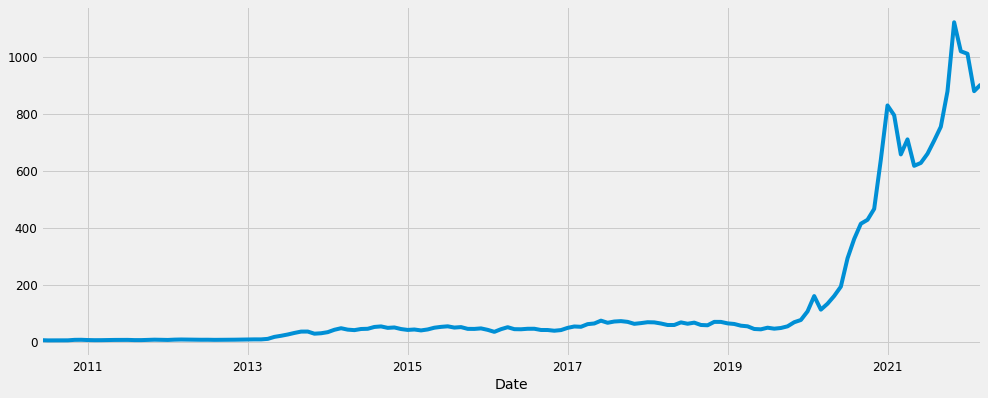

In [16]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

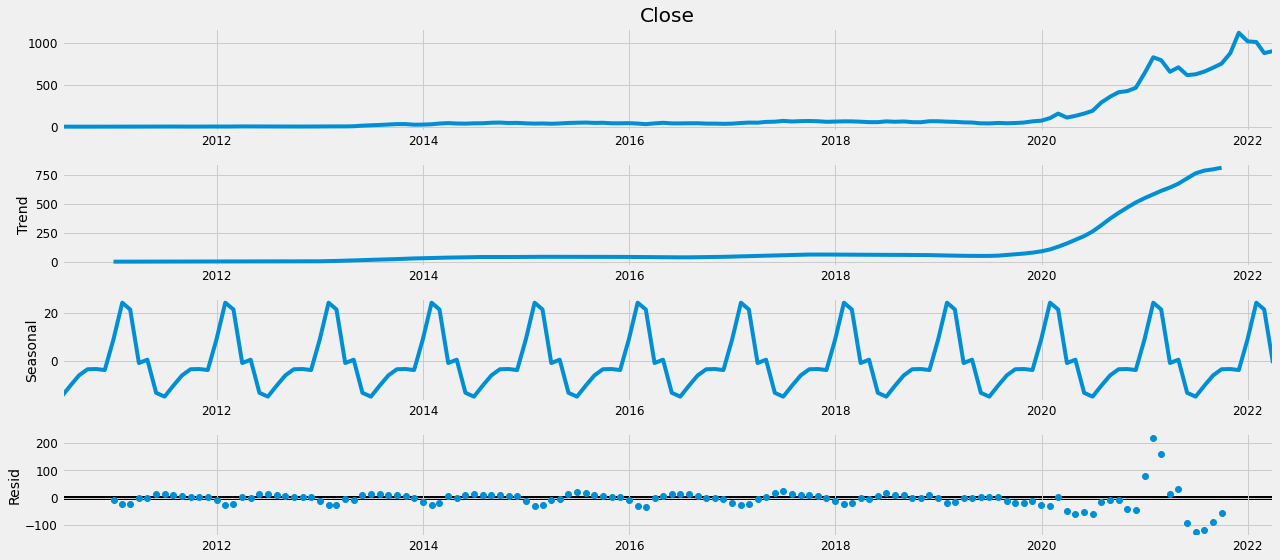

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the Close price is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:`

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print('pdq =', pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('seasonal_pdq ', seasonal_pdq)

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

pdq = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal_pdq  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

In [20]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1999.5673100768145, 1756.0592477084551, 1708.0727403115297, 1525.1661365082794, 1670.1269797051282, 1637.6515256806142, 1539.3259080834766, 1526.946319961761, 1812.7187117761891, 1585.7384981146124, 1539.3797687898125, 1370.8251873783342, 1515.7629162484945, 1486.3755371705693, 1397.7192411533745, 1372.816354189012, 1439.0176217514118, 1328.5093118277098, 1368.2943526157983, 1222.2294536766738, 1337.797677500632, 1330.4409845795103, 1233.1887266932954, 1223.0097318776805, 1424.9954580579029, 1315.418773714703, 1351.1777085960757, 1210.0647645392642, 1334.0275017217177, 1317.3869514632224, 1231.2752950286872, 1210.9796195744095, 1445.5977923423159, 1336.3678029659725, 1378.2773348933526, 1265.4638798232638, 1336.36679368923, 1338.3665338589449, 1234.0037903491293, 1237.3138579941692, 1433.6083365144068, 1324.9551810490657, 1359.981334336689, 1268.556783941975, 1333.9905490461147, 1326.7077900364834, 1232.733865351578, 1270.5561610284024, 1433.3751739440931, 1324.2200346276684, 1364.943

In [21]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25451D+00    |proj g|=  8.95856D-02

At iterate    5    f=  4.24794D+00    |proj g|=  1.68095D-02

At iterate   10    f=  4.23994D+00    |proj g|=  1.60909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   9.044D-06   4.240D+00
  F =   4.2396646638706486     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2032      0.070      2.898      0.004       0.066       0.341
ma.S.L12      -0.7319      0.103     -7.116      0.000      -0.933      -0.530
sigma2      1995.3407    131.415     15.183      0.000    1737.771    2252.910


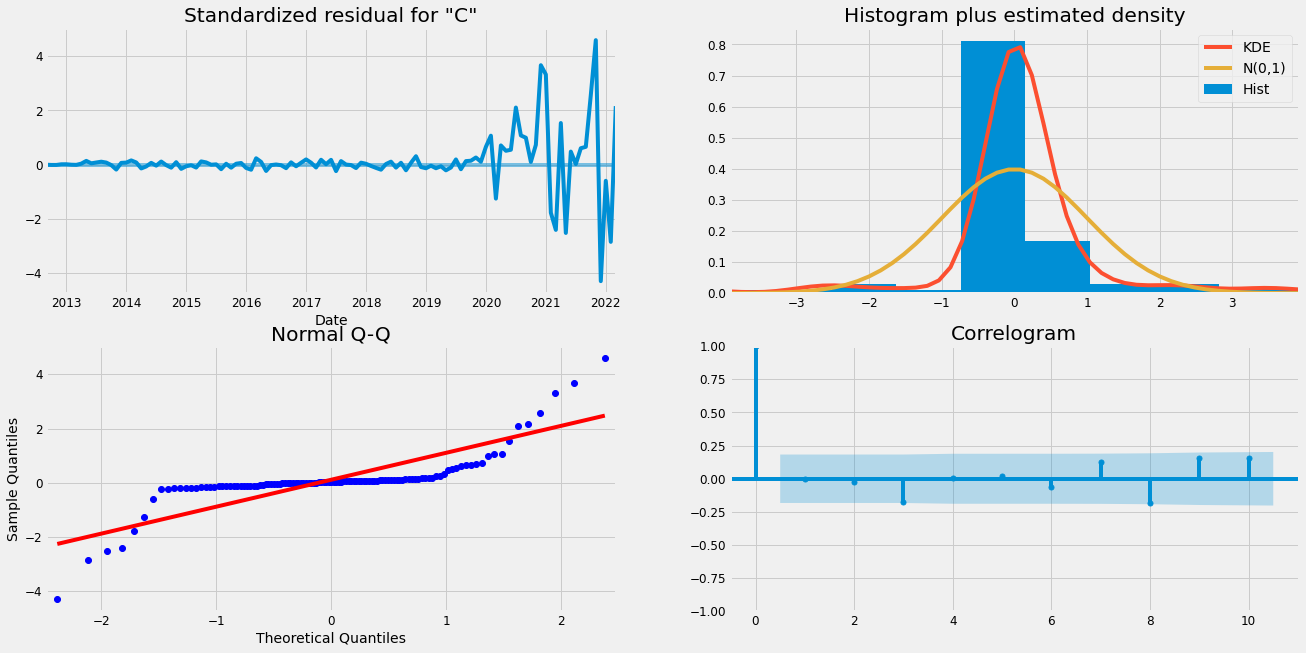

In [22]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

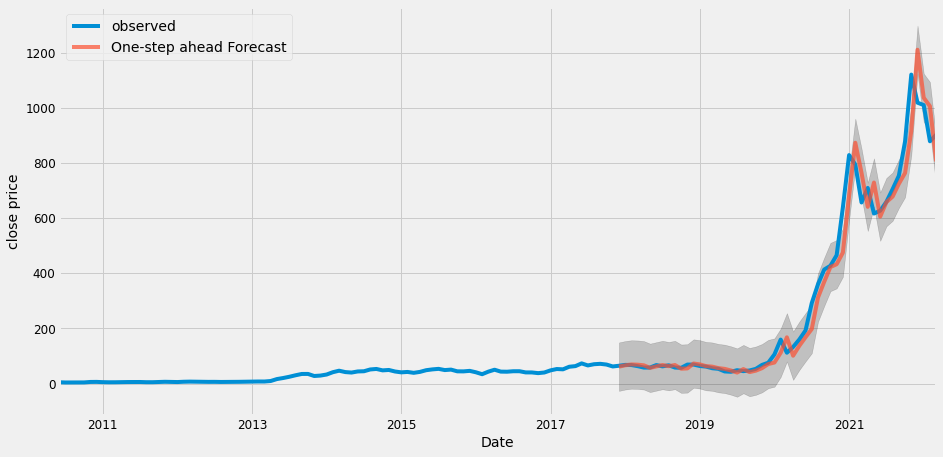

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci = pred.conf_int()

ax = monthly_mean['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [24]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4388.93


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 66.25


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

## Calculating the Roy Ratio for past
Since the stock prices differ greatly, we cannot just use the absolute value of the mean sqaured error to compare volatility between stocks. Thus, we use something we call the Roy ratio which is equal to the predicted value divided by the volatile range.

In [26]:
actual=pd.DataFrame(monthly_mean['2017-12-31':'2022-03-31'])

result = pd.concat([pred_ci, actual], axis=1).reindex(pred_ci.index)
display(result)

,lower Close,upper Close,Close
Date,,,
2017-12-31,-26.555854,149.064486,64.568201
2018-01-31,-21.584674,154.035666,67.716666
2018-02-28,-18.560382,157.059958,67.155474
2018-03-31,-19.291159,156.329180,63.196666
2018-04-30,-21.578813,154.041527,57.954572
2018-05-31,-30.914902,144.705436,57.970455
2018-06-30,-25.681713,149.938568,67.120095
2018-07-31,-20.553222,155.056889,62.394952
2018-08-31,-24.598206,150.788746,66.242869


In [27]:
diff_result = result.diff()
display(diff_result)

,lower Close,upper Close,Close
Date,,,
2017-12-31,NaN,NaN,NaN
2018-01-31,4.971179,4.971179,3.148466
2018-02-28,3.024292,3.024292,-0.561192
2018-03-31,-0.730777,-0.730777,-3.958808
2018-04-30,-2.287654,-2.287654,-5.242094
2018-05-31,-9.336089,-9.336091,0.015883
2018-06-30,5.233189,5.233133,9.149641
2018-07-31,5.128491,5.118321,-4.725143
2018-08-31,-4.044983,-4.268143,3.847917


In [28]:
print(pred_ci)


            lower Close  upper Close
Date                                
2017-12-31   -26.555854   149.064486
2018-01-31   -21.584674   154.035666
2018-02-28   -18.560382   157.059958
2018-03-31   -19.291159   156.329180
2018-04-30   -21.578813   154.041527
2018-05-31   -30.914902   144.705436
2018-06-30   -25.681713   149.938568
2018-07-31   -20.553222   155.056889
2018-08-31   -24.598206   150.788746
2018-09-30   -20.410590   154.967177
2018-10-31   -33.742941   141.634448
2018-11-30   -32.781776   142.595597
2018-12-31   -14.996120   160.381252
2019-01-31   -18.079657   157.297715
2019-02-28   -24.448570   150.928802
2019-03-31   -26.264057   149.113315
2019-04-30   -31.763876   143.613497
2019-05-31   -34.427343   140.950028
2019-06-30   -40.280081   135.097260
2019-07-31   -47.821491   127.550445
2019-08-31   -35.133282   140.120072
2019-09-30   -46.054035   129.194434
2019-10-31   -40.863906   134.384362
2019-11-30   -31.791005   143.457255
2019-12-31   -16.888443   158.359816
2

In [29]:
roy_ratio=(diff_result['Close'])/(-pred_ci['lower Close']+pred_ci['upper Close'])
roy_ratio # predicted_mean/volatility around mean

Date
2017-12-31         NaN
2018-01-31    0.017928
2018-02-28   -0.003195
2018-03-31   -0.022542
2018-04-30   -0.029849
2018-05-31    0.000090
2018-06-30    0.052099
2018-07-31   -0.026907
2018-08-31    0.021940
2018-09-30   -0.046832
2018-10-31   -0.005879
2018-11-30    0.067856
2018-12-31   -0.000440
2019-01-31   -0.029212
2019-02-28   -0.012277
2019-03-31   -0.034179
2019-04-30   -0.012660
2019-05-31   -0.053531
2019-06-30   -0.006841
2019-07-31    0.032691
2019-08-31   -0.019720
2019-09-30    0.013876
2019-10-31    0.033202
2019-11-30    0.082107
2019-12-31    0.044959
2020-01-31    0.172286
2020-02-29    0.306751
2020-03-31   -0.272009
2020-04-30    0.119256
2020-05-31    0.155011
2020-06-30    0.187296
2020-07-31    0.566747
2020-08-31    0.388347
2020-09-30    0.305033
2020-10-31    0.078287
2020-11-30    0.219221
2020-12-31    0.988736
2021-01-31    1.084364
2021-02-28   -0.196983
2021-03-31   -0.784721
2021-04-30    0.301494
2021-05-31   -0.530114
2021-06-30    0.058035
2021-0

## Producing and visualizing forecasts

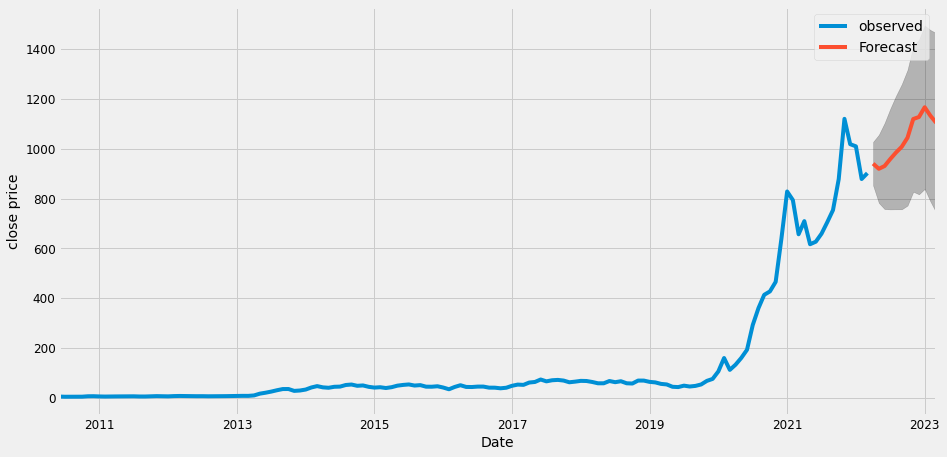

In [30]:
pred_uc = results.get_forecast(steps=12) # each step is 1 month. 12 to predict 1 year
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Our model clearly captured close price seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Calculating roy Ratio for Future allocation

In [31]:
roy_ratio_future_tesla=((pred_ci['upper Close']+pred_ci['lower Close'])/2 )/(pred_ci['upper Close']-pred_ci['lower Close'])
roy_ratio_future_tesla # predicted_mean/volatility around mean



2022-04-30    5.370838
2022-05-31    3.357082
2022-06-30    2.693276
2022-07-31    2.369522
2022-08-31    2.159158
2022-09-30    2.006430
2022-10-31    1.916843
2022-11-30    1.916511
2022-12-31    1.815982
2023-01-31    1.779600
2023-02-28    1.644552
2023-03-31    1.533593
Freq: M, dtype: float64

# Repeating for AAPL

In [32]:
stock2=(web.DataReader("AAPL", data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
stock2=pd.DataFrame(stock2)
stock2 = stock2.sort_values('Date')
type(stock2)


stock2.isnull().sum()

stock2

stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
stock2
stock2.head()


,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286


In [33]:
stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')

In [34]:
stock2

,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286
...,...,...
2948,2022-03-14,150.619995
2949,2022-03-15,155.089996
2950,2022-03-16,159.589996
2951,2022-03-17,160.619995


In [35]:
stock2 = stock2.set_index('Date')
stock2.index

DatetimeIndex(['2010-06-28', '2010-06-29', '2010-06-30', '2010-07-01',
               '2010-07-02', '2010-07-06', '2010-07-07', '2010-07-08',
               '2010-07-09', '2010-07-12',
               ...
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18'],
              dtype='datetime64[ns]', name='Date', length=2953, freq=None)

In [36]:
display(stock2)
stock2.index = pd.to_datetime(stock2.index)

monthly_mean2 = stock2.Close.resample('M').mean()



,Close
Date,
2010-06-28,9.582143
2010-06-29,9.148929
2010-06-30,8.983214
2010-07-01,8.874286
2010-07-02,8.819286
...,...
2022-03-14,150.619995
2022-03-15,155.089996
2022-03-16,159.589996


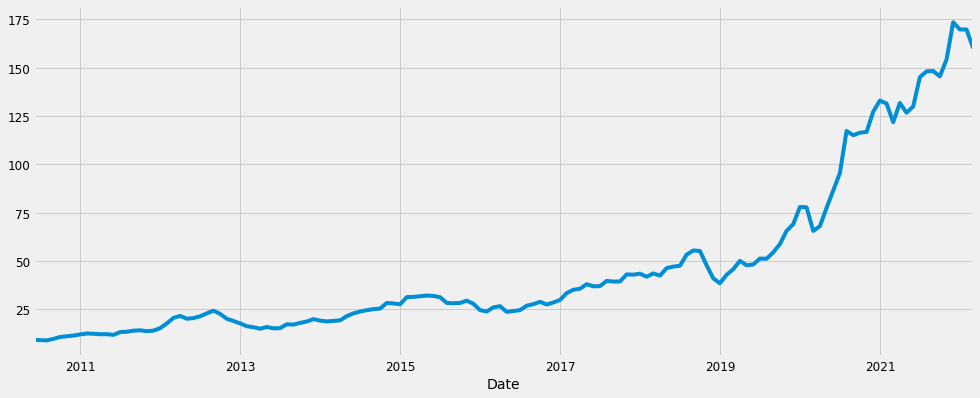

In [37]:
monthly_mean2.plot(figsize=(15, 6))
plt.show()

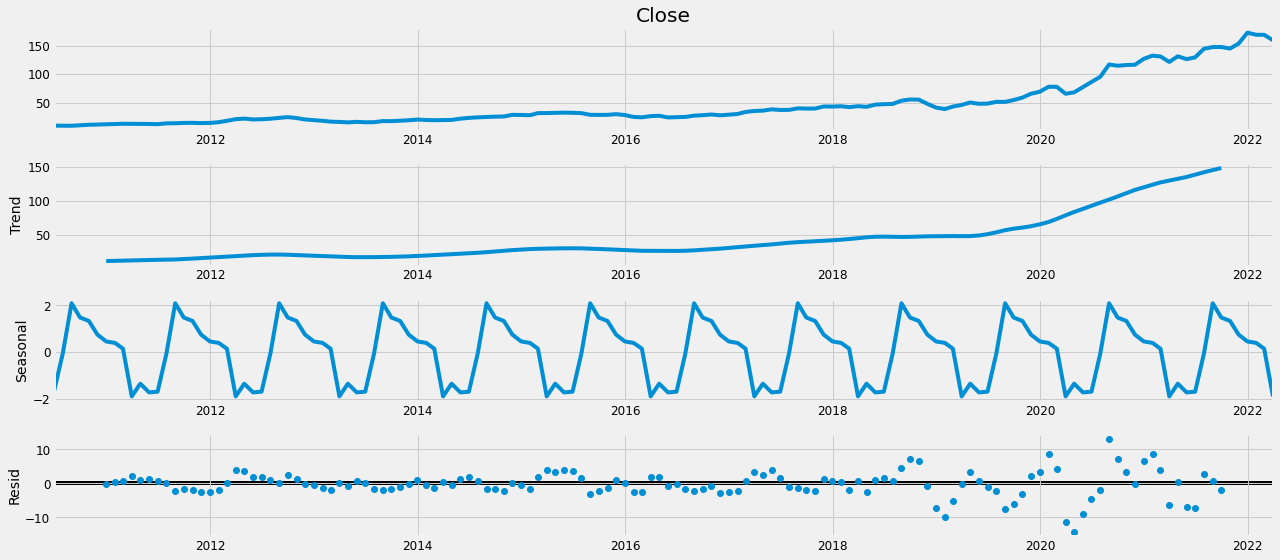

In [38]:
decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
fig = decomposition2.plot()
plt.show()

In [ ]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

In [40]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1568.5571161997175, 1336.606478794166, 1166.3614235053599, 1026.8927548820425, 1047.9325238495162, 1033.3296573668022, 1022.5295931072233, 983.5193195351595, 1379.810695102695, 1170.659220740452, 1011.8434000633681, 905.9258892443479, 928.9954234033748, 904.207008582681, 910.1726422087058, 869.8658027962691, 810.2074028511965, 748.7990340558435, 779.149220405656, 685.4561607057943, 750.4181507604264, 745.7789054111217, 684.7134040445293, 681.8069709570804, 799.6250875487035, 741.0102413073515, 774.3452711664786, 680.5795245174078, 748.6342039930919, 739.8111295995445, 684.7072263311103, 676.8579311419725, 802.9460077915935, 746.1430944006152, 785.7984112010984, 690.7472986562386, 745.0118914065974, 746.5032857040678, 685.6184497090434, 687.3500764767299, 797.6912695924506, 741.4042434271465, 780.5383301039628, 686.6302030995786, 745.280437116097, 742.0358701777095, 686.105285894461, 683.0578454366636, 804.2081632141674, 745.7344273354452, 779.4739489412437, 685.8476079046121, 743.7570

In [41]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results2 = mod.fit()

print(results2.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37528D+00    |proj g|=  6.54422D-02

At iterate    5    f=  2.35550D+00    |proj g|=  5.78315D-03

At iterate   10    f=  2.35513D+00    |proj g|=  1.16129D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.161D-07   2.355D+00
  F =   2.3551335603590582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1486      0.077      1.936      0.053      -0.002       0.299
ar.S.L12      -0.6123      0.139     -4.395      0.000      -0.885      -0.339
ma.S.L12      -0.0571      0.155     -0.369      0.712      -0.361       0.246
sigma2        19.6483      1.693     11.604      0.000      16.330      22.967


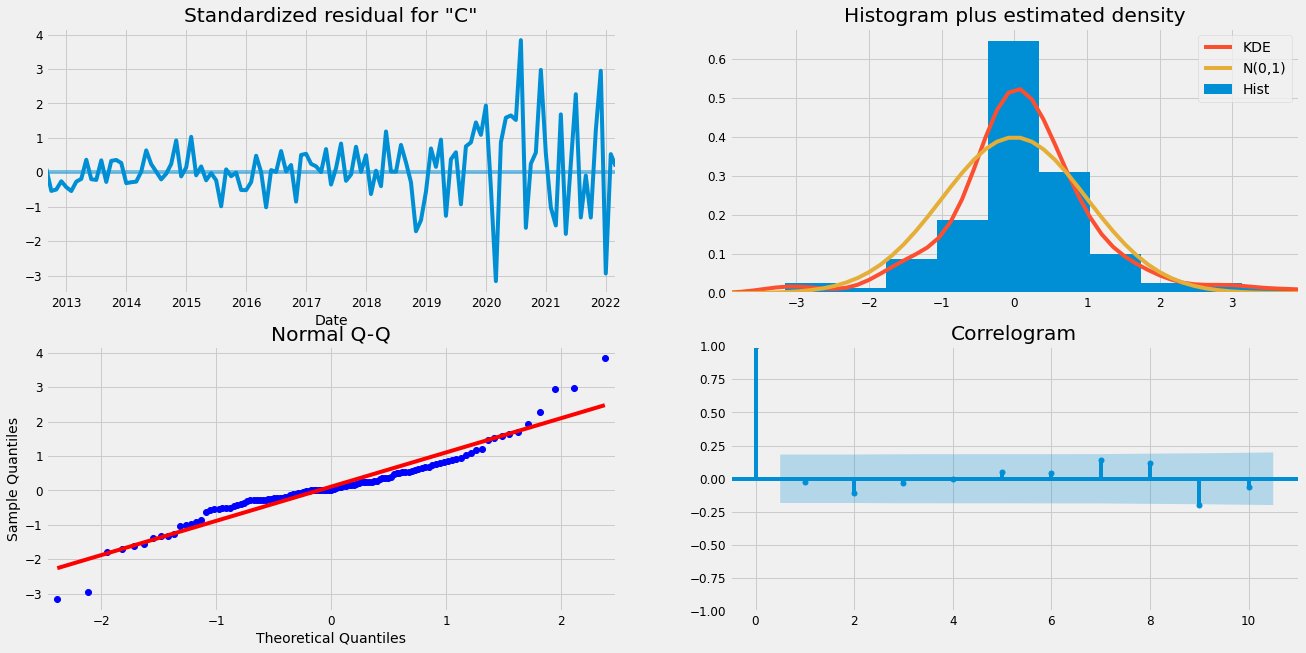

In [42]:
results2.plot_diagnostics(figsize=(20, 10))
plt.show()

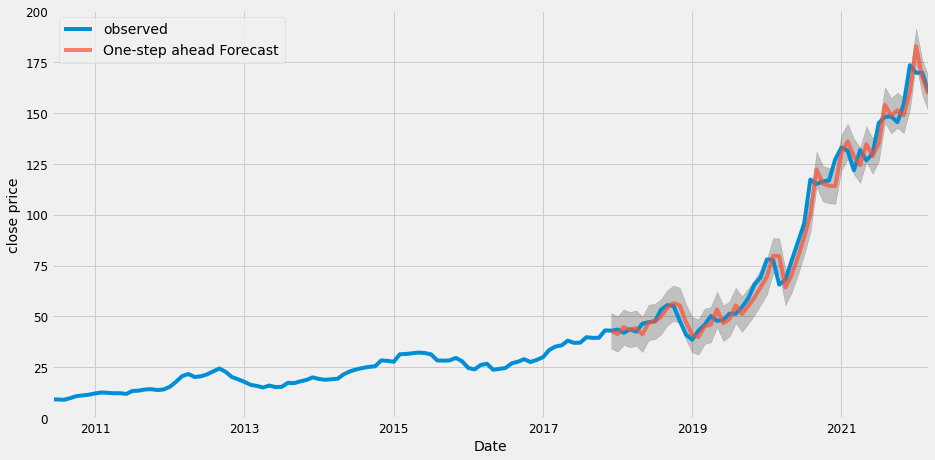

In [43]:
pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci2 = pred2.conf_int()

ax = monthly_mean2['2010':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

In [103]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = monthly_mean2['2017-12-31':]

# Compute the mean square error
mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse2, 2)))

The Mean Squared Error of our forecasts is 39.13


In [104]:
actual2=pd.DataFrame(monthly_mean2['2017-12-31':'2022-03-31'])

result2 = pd.concat([pred_ci2, actual2], axis=1).reindex(pred_ci2.index)
display(result2)
diff_result2 = result2.diff()
display(diff_result2)

,lower Close,upper Close,Close
Date,,,
2017-12-31,34.226471,51.602113,42.972875
2018-01-31,32.610261,49.985902,43.501309
2018-02-28,36.018858,53.394500,41.909737
2018-03-31,34.726736,52.102378,43.624048
2018-04-30,35.557304,52.932946,42.458572
2018-05-31,32.438835,49.814477,46.384205
2018-06-30,38.368432,55.744074,47.155357
2018-07-31,38.805833,56.181475,47.577857
2018-08-31,41.120006,58.495648,53.336522


,lower Close,upper Close,Close
Date,,,
2017-12-31,NaN,NaN,NaN
2018-01-31,-1.616211,-1.616211,0.528434
2018-02-28,3.408597,3.408597,-1.591573
2018-03-31,-1.292122,-1.292122,1.714311
2018-04-30,0.830568,0.830568,-1.165476
2018-05-31,-3.118469,-3.118469,3.925633
2018-06-30,5.929597,5.929597,0.771153
2018-07-31,0.437401,0.437401,0.422500
2018-08-31,2.314172,2.314172,5.758665


In [105]:
roy_ratio2=((diff_result2['Close'] )/(pred_ci2['upper Close']-pred_ci2['lower Close']))
roy_ratio2 # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower


Date
2017-12-31         NaN
2018-01-31    0.030412
2018-02-28   -0.091598
2018-03-31    0.098662
2018-04-30   -0.067075
2018-05-31    0.225927
2018-06-30    0.044381
2018-07-31    0.024316
2018-08-31    0.331422
2018-09-30    0.125572
2018-10-31   -0.017669
2018-11-30   -0.426027
2018-12-31   -0.388035
2019-01-31   -0.145320
2019-02-28    0.252677
2019-03-31    0.166410
2019-04-30    0.247795
2019-05-31   -0.132981
2019-06-30    0.024393
2019-07-31    0.176215
2019-08-31   -0.003721
2019-09-30    0.187580
2019-10-31    0.248790
2019-11-30    0.391841
2019-12-31    0.201506
2020-01-31    0.509197
2020-02-29   -0.009290
2020-03-31   -0.702513
2020-04-30    0.143046
2020-05-31    0.540977
2020-06-30    0.515389
2020-07-31    0.524565
2020-08-31    1.250803
2020-09-30   -0.125148
2020-10-31    0.074124
2020-11-30    0.023758
2020-12-31    0.602249
2021-01-31    0.330715
2021-02-28   -0.086631
2021-03-31   -0.555967
2021-04-30    0.572155
2021-05-31   -0.289420
2021-06-30    0.182706
2021-0

In [106]:
def get_ratio(name):
    stock2=(web.DataReader(name, data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
    stock2=pd.DataFrame(stock2)
    stock2 = stock2.sort_values('Date')
    type(stock2)


    stock2.isnull().sum()

    

    stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
    stock2
    stock2.head()

    stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')
    stock2 = stock2.set_index('Date')
    stock2.index = pd.to_datetime(stock2.index)

    monthly_mean2 = stock2.Close.resample('M').mean()
    decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
    l_param = []
    l_param_seasonal=[]
    l_results_aic=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

            
                l_param.append(param)
                l_param_seasonal.append(param_seasonal)
                l_results_aic.append(results.aic)
            except:
                continue
    minimum=l_results_aic[0]
    for i in l_results_aic[1:]:
        if i < minimum: 
            minimum = i
    i=l_results_aic.index(minimum)
    mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results2 = mod.fit()
    pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date

    ax = monthly_mean2['2010':].plot(label='observed')
    pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    y_forecasted2 = pred2.predicted_mean
    y_truth2 = monthly_mean2['2017-12-31':]

    # Compute the mean square error
    mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
    actual2=pd.DataFrame(monthly_mean2['2017-12-31':'2022-03-31'])

    result2 = pd.concat([pred_ci2, actual2], axis=1).reindex(pred_ci2.index)
    diff_result2 = result2.diff()
    roy_ratio2=((diff_result2['Close'] )/(pred_ci2['upper Close']-pred_ci2['lower Close']))
    roy_ratio2 # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower
    return roy_ratio2

In [ ]:
stock_list=["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
everything = pd.DataFrame()
for ns in stock_list:
    print(ns)
    temp=get_ratio(ns)
    everything = pd.concat([everything, temp], axis=1).reindex(temp.index)
    everything.rename(columns={'0': ns}, inplace=True)
    display(everything)
everything.columns = ["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]


In [114]:
display(everything)

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.310658,5.275282,1.388078,-0.078657,51.214984,-0.178375,1.622952,3.571564,0.290332,7.509172,26.486298,0.020940,2.309740
2018-02-28,-0.091598,-0.138650,-0.151167,-0.187351,-2.449615,-0.643383,-0.701637,3.400048,-0.003133,17.137902,79.462050,-0.138593,-0.321067
2018-03-31,3.275170,-0.002106,-0.219988,-0.276956,6.273352,-0.007829,-0.083315,-0.034877,-0.025095,12.533376,77.918102,-0.023593,-0.124274
2018-04-30,-0.067075,-0.278633,-0.111349,-0.105512,-3.211064,-0.209489,-0.085094,-0.171176,-0.254708,-0.188578,-0.274056,100.000000,-0.187482
2018-05-31,5.065933,-0.503909,-0.094551,-0.350002,43.333795,-0.225871,-0.288829,0.596970,-0.061807,19.940749,31.062553,-0.015326,-0.058170
2018-06-30,0.558739,-0.056509,0.537564,0.785683,49.523593,0.335630,-0.071527,-0.181328,3.518649,6.191897,38.108840,-0.028085,0.439405
2018-07-31,0.587240,-0.197348,2.252325,-0.034942,69.445503,2.508469,6.955539,3.081642,5.936928,7.061436,-0.150676,1.436910,0.734008
2018-08-31,7.889093,1.500452,2.046845,3.871717,52.169491,7.180248,7.963363,7.716772,1.755864,2.164043,-2.029129,1.256412,4.485699


In [112]:
for i,row in everything.iterrows():
    sum = 0
    print(i)
    stockNames = []
    for index, value in row.iteritems():
        if value>0:
            sum+=value
            print(index, value)
            stockNames.append(index)
    print(stockNames)
    print('Sum: ', sum, '\n')
    
    for stock in stockNames:
        stockPercentage = row[stock]/sum * 100
        print(stock, 'value:', stockPercentage)
        # !: mutates the everthing dataframe, and takes a long time to re-run the code above so be careful
        everything.at[i, stock] = stockPercentage
        
        

    print('\n')
    
    

2017-12-31 00:00:00
[]
Sum:  0 



2018-01-31 00:00:00
AAPL 0.31065820985458015
CAH 5.275281741168734
CMCSA 1.3880784280162397
GOOG 51.214983800593984
JNJ 1.6229522989226957
JPM 3.57156384466421
K 0.2903315843257133
MA 7.509171993557158
NFLX 26.48629823911791
UL 0.020939779171507158
WBA 2.309740080607284
['AAPL', 'CAH', 'CMCSA', 'GOOG', 'JNJ', 'JPM', 'K', 'MA', 'NFLX', 'UL', 'WBA']
Sum:  100.00000000000003 

AAPL value: 0.31065820985458004
CAH value: 5.275281741168732
CMCSA value: 1.3880784280162393
GOOG value: 51.21498380059397
JNJ value: 1.6229522989226954
JPM value: 3.571563844664209
K value: 0.29033158432571327
MA value: 7.509171993557155
NFLX value: 26.486298239117907
UL value: 0.02093977917150715
WBA value: 2.309740080607283


2018-02-28 00:00:00
JPM 3.400048405316553
MA 17.13790165898035
NFLX 79.46204993570309
['JPM', 'MA', 'NFLX']
Sum:  100.0 

JPM value: 3.400048405316553
MA value: 17.13790165898035
NFLX value: 79.46204993570309


2018-03-31 00:00:00
AAPL 3.275169512704009
GOO

In [117]:
for i, row in everything.iterrows():
    for index, value in row.iteritems():
        if value<0:
            print(i, index)
            everything.at[i, index] = 0

2018-01-31 00:00:00 DISH
2018-01-31 00:00:00 HSY
2018-02-28 00:00:00 AAPL
2018-02-28 00:00:00 CAH
2018-02-28 00:00:00 CMCSA
2018-02-28 00:00:00 DISH
2018-02-28 00:00:00 GOOG
2018-02-28 00:00:00 HSY
2018-02-28 00:00:00 JNJ
2018-02-28 00:00:00 K
2018-02-28 00:00:00 UL
2018-02-28 00:00:00 WBA
2018-03-31 00:00:00 CAH
2018-03-31 00:00:00 CMCSA
2018-03-31 00:00:00 DISH
2018-03-31 00:00:00 HSY
2018-03-31 00:00:00 JNJ
2018-03-31 00:00:00 JPM
2018-03-31 00:00:00 K
2018-03-31 00:00:00 UL
2018-03-31 00:00:00 WBA
2018-04-30 00:00:00 AAPL
2018-04-30 00:00:00 CAH
2018-04-30 00:00:00 CMCSA
2018-04-30 00:00:00 DISH
2018-04-30 00:00:00 GOOG
2018-04-30 00:00:00 HSY
2018-04-30 00:00:00 JNJ
2018-04-30 00:00:00 JPM
2018-04-30 00:00:00 K
2018-04-30 00:00:00 MA
2018-04-30 00:00:00 NFLX
2018-04-30 00:00:00 WBA
2018-05-31 00:00:00 CAH
2018-05-31 00:00:00 CMCSA
2018-05-31 00:00:00 DISH
2018-05-31 00:00:00 HSY
2018-05-31 00:00:00 JNJ
2018-05-31 00:00:00 K
2018-05-31 00:00:00 UL
2018-05-31 00:00:00 WBA
2018-06-30

## This represents the portfolio percentages at each point in time
- From here, we will calculate the portfolio returns if we rebalance at the end of every month
- If all the cells in a row are 0, then the entire portfolio will be converted to cash for that month

In [121]:
everything

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.310658,5.275282,1.388078,0.000000,51.214984,0.000000,1.622952,3.571564,0.290332,7.509172,26.486298,0.020940,2.309740
2018-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400048,0.000000,17.137902,79.462050,0.000000,0.000000
2018-03-31,3.275170,0.000000,0.000000,0.000000,6.273352,0.000000,0.000000,0.000000,0.000000,12.533376,77.918102,0.000000,0.000000
2018-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
2018-05-31,5.065933,0.000000,0.000000,0.000000,43.333795,0.000000,0.000000,0.596970,0.000000,19.940749,31.062553,0.000000,0.000000
2018-06-30,0.558739,0.000000,0.537564,0.785683,49.523593,0.335630,0.000000,0.000000,3.518649,6.191897,38.108840,0.000000,0.439405
2018-07-31,0.587240,0.000000,2.252325,0.000000,69.445503,2.508469,6.955539,3.081642,5.936928,7.061436,0.000000,1.436910,0.734008
2018-08-31,7.889093,1.500452,2.046845,3.871717,52.169491,7.180248,7.963363,7.716772,1.755864,2.164043,0.000000,1.256412,4.485699


TODO:
- use the stock prices to get the monthly return corresponding to the everything table
- use the algorithm in control.ipynb to calculate the total portfolio return for each month
- compound everything and get the total return and sharpe ratio over the whole timeframe